<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/colab/iip_model_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# クラス活性化マッピング（class activation mapping; CAM）

CNNは，画像のどこの局所特徴に基づき出力を算出しているのでしょうか．[**特徴マップ（class activation map; CAM)feature maps）**](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)を可視化します．

In [1]:
#@title 4D arrayの画像・特徴マップを表示する関数を定義します．
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn


def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4), mag=2, mean=0., std =1.):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*mag, rc[0]*mag))
    if len(img_arr) != 1:
        axes = axes.flatten()
    else: 
        axes = [axes]
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# plot feature maps
def plotFeaturemaps(maps, max_ch=12, top=None, figsize=(8, 3), mag=1):

    if maps.ndim == 1:
        plt.figure(figsize=figsize)
        plt.bar(np.arange(maps.shape[0]), maps, width=1.0)
        plt.tight_layout()
        plt.show()
        return

    if maps.ndim != 3: return
    # maps.shape = (ch, h, w)
    if top is not None:
        nmaps = min(top, maps.shape[0])
        nrows, ncols = 1, nmaps
        channels = np.argsort(-np.sum(np.abs(maps.reshape((maps.shape[0],-1))**2), axis=1))[:nmaps]
    else:
        nmaps = min(maps.shape[0], max_ch*max_ch)
        ncols = int(np.ceil(np.sqrt(nmaps)))
        nrows = int(np.floor(nmaps / ncols))
        nmaps = nrows * ncols
        channels = range(nmaps)

    norm = tsn(vmin=np.minimum(maps[:].min(),-1e-6), vcenter=0, vmax=np.maximum(maps[:].max(),1e-6)) # maps[channels]
    fig = plt.figure(figsize=(ncols*mag, nrows*mag))
    for ch in range(nmaps):
        ax1 = fig.add_subplot(nrows, ncols, ch+1)
        ax1.imshow(maps[channels[ch]], cmap='bwr_r', norm=norm)#, aspect='equal')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

from matplotlib import cm as cmap
# x[H,W]
def toColorImg(x, cm='bwr_r'):
    norm = tsn(vmin=np.minimum(x[:].min(),-1e-6), vcenter=0, vmax=np.maximum(x[:].max(),1e-6)) # maps[channels]
    sm = cmap.ScalarMappable(norm=norm, cmap=cm)
    return sm.to_rgba(x)[:,:,:3]

## 学習済みのCNNモデルを読み込みます．

- CNNモデルは，torch.saveでGoogleドライブに保存されているものとします．
- CNNモデルの場所とファイル名を model_path と model_name に設定してください．
- CNNモデルは，クラス名my_modelの実体であるとします．
    - my_modelは，nn.Sequentialで作られた features, avgpool, classifierから構成されるものとします．
    - classifier は全結合層nn.Linearをひとつだけをもつものとします．
    - features はカラー画像の入力から特徴マップを作り，その特徴マップは avgpool を経て classifier へ渡されるものとします．
    - avgpoolは[全体平均プーリング（global average pooling; GAP）](https://paperswithcode.com/method/global-average-pooling)を担う層と仮定します．


In [2]:
from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/"

#model_path=""
model_name = "model.pkl"

Mounted at /content/drive


In [3]:
from torch import nn

# model definition
class my_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # self.features = nn.Sequential()
        # self.avgpool = nn.Sequential()
        # self.classifier = nn.Sequential()

    def forward(self, x):
        features_out = self.features(x)
        gap = self.avgpool(features_out).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
        classifier_out = self.classifier(gap)
        #classifier_out = self.fc1(gap)

        return classifier_out, features_out

# load
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load(model_path + model_name, map_location=device)
model.eval()
print(model)

model_linear = model.classifier[0]

my_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [4]:
categories = ['ants', 'bees']
hparam = {'image_size': (224, 224),
          'mean_color': [0.485, 0.456, 0.406], 'std_color': [0.229, 0.224, 0.225]}

# ants
#uri = "https://www.terro.com/media/Articles/TERRO/Get-Rid-of-Sugar-Ants-in-3-Steps.jpg"
#uri = "https://i.natgeofe.com/n/ab3c5297-7321-4846-9f54-3c4114165f2d/ants_thumb_3x4.jpg"
#uri = "https://static01.nyt.com/images/2018/08/19/science/21SCI-TAKE/21SCI-TAKE-videoSixteenByNine3000.jpg"
#uri = "https://images.theconversation.com/files/280292/original/file-20190619-171183-p0runh.jpg"
#uri = "https://thisismygarden.com/wp-content/uploads/2020/07/controlling-ants-on-plants-1.jpg"
#uri = "https://images.theconversation.com/files/280045/original/file-20190618-118543-13mbljf.jpg"
#uri = "https://api.time.com/wp-content/uploads/2015/07/ants-carrying-leaves.jpg"

# bees
uri = "https://images2.minutemediacdn.com/image/upload/c_crop,h_1238,w_2200,x_0,y_163/f_auto,q_auto,w_1100/v1621529138/shape/mentalfloss/53691-gettyimages-165987177.jpg"
#uri = "https://media-cldnry.s-nbcnews.com/image/upload/t_fit-2000w,f_auto,q_auto:best/newscms/2017_12/1941536/170322-honey-bee-mn-1700.jpg"
#uri = "https://grist.org/wp-content/uploads/2015/04/bee-e1452114220653.jpg"
#uri = "https://static01.nyt.com/images/2018/06/19/science/08BEES/08BEES-facebookJumbo.jpg"

# ants and bees
#uri = "https://www.oneindia.com/img/2016/01/28-1453966107-ants-honey-bee.jpg"

(height, width, channels) = (619, 1100, 3)


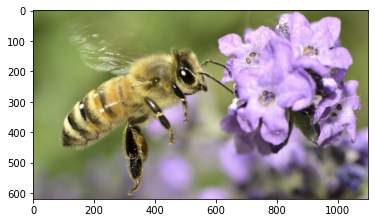

In [5]:
#@title 画像をダウンロードして表示します．
import imageio
cimg = imageio.imread(uri)

# resize
from PIL import Image
pimg = Image.fromarray(cimg)

import numpy as np
#cimg = np.array(pimg.resize((cimg.shape[1] * 128 // cimg.shape[0], 128)))
cimg = np.array(pimg)

print("(height, width, channels) =", cimg.shape)
import matplotlib.pyplot as plt
plt.imshow(cimg)
plt.show()

In [6]:
#@title モデルの出力と特徴マップを得ます．
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(hparam['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=hparam['mean_color'], std=hparam['std_color']),
])

in_img = preprocess(pimg)

model.eval()
with torch.no_grad():
    output, features_out = model(in_img.unsqueeze(0).to(device))

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Show the classification result
top_prob, top_catid = torch.topk(probabilities, len(categories))
print("Classified as \033[1m", categories[top_catid[0]], "\033[0m, model output =", output)
for i in range(top_prob.size(0)):
    print(categories[top_catid[i]], "(", top_catid[i].cpu().numpy(), ")", "{:.2f} %".format(top_prob[i].item()*100))

Classified as  bees , model output = tensor([[-0.4888,  0.4324]])
bees ( 1 ) 71.53 %
ants ( 0 ) 28.47 %


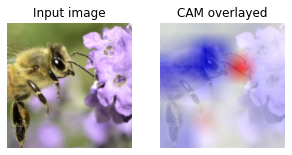

ants avg=-0.55,  bees avg=0.52,  

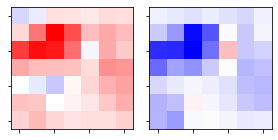

In [7]:
#@title CAMを作成して表示します．

# CAM with a 1x1 filter
class_activation_mapper = torch.nn.Conv2d(model_linear.weight.shape[1], model_linear.weight.shape[0], 1, padding=0, bias=False)
class_activation_mapper.weight = torch.nn.Parameter(model_linear.weight.unsqueeze(-1).unsqueeze(-1))

with torch.no_grad():
    cam = class_activation_mapper(features_out).squeeze()
    cam_avgs = cam.mean([-2,-1]).cpu().numpy().tolist()

ccam = toColorImg(cam[top_catid[0]], cm='bwr_r')#.transpose(2,0,1)
# resize cam
ccam_normalizer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=hparam['mean_color'], std=hparam['std_color']),
        transforms.Resize(hparam['image_size'])#, interpolation=0),
    ])
ccam = ccam_normalizer(ccam)

# overlay cam on input
alpha = 0.25
cam_image = in_img*alpha + ccam*(1-alpha)

# display input and CAM images
plotImages([in_img, cam_image], ["Input image", "CAM overlayed"], mag=2.2, mean=hparam['mean_color'], std=hparam['std_color'])
for cat, acm in zip(categories, cam_avgs): print(cat, "avg={:.2f},  ".format(acm), end='')
plotFeaturemaps(cam.detach().cpu().numpy(), mag=2)